In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Define data paths

In [3]:
data_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Data/2_eye/New')
game_dir = os.path.join(data_dir, 'game')
eyet_dir = os.path.join(data_dir, 'eyet')
mous_dir = os.path.join(data_dir, 'mous')
game_files = [os.path.join(game_dir, g) for g in os.listdir(game_dir) if g[-3:]=='csv']
eyet_files = [os.path.join(eyet_dir, e) for e in os.listdir(eyet_dir) if e[-3:]=='csv']
mous_files = [os.path.join(mous_dir, m) for m in os.listdir(mous_dir) if m[-3:]=='csv']

# Load data

Notes:

1. Computer logs timestamps as "0", so when computer makes last move, we lose time index
2. Solution: load raw game data with "ready" entries, as these have timestamp for game beginning.
3. Now requires further processing :(

In [4]:
subject_initial_map = [g[-6:-4] for g in game_files]
subject_initial_map = dict(zip(subject_initial_map, np.arange(len(subject_initial_map))))

top = 192
bottom = 506
left = 177
right = 889
width = right - left
height = bottom - top

def load_game_file(gf):
    mfnames = ['idx', 'id', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'ts', 'mt', 'mx']

    D = pd.read_csv(gf, names=mfnames)
    D['subject'] = gf[-6:-4]
    D['human'] = D['subject'].map(subject_initial_map)
    D['tstemp'] = D['ts'].shift(-1)
    D['rttemp'] = D['rt'].shift(-1)
    D.loc[D['rt']==0, 'ts'] = D.loc[D['rt']==0, 'tstemp'] - D.loc[D['rt']==0, 'rttemp']
    return D.set_index('ts')

def load_mous_file(mf):
    # todo: strip values from during computer move/ready states... (kill me)
    mfnames = ['idx', 'id', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'ts', 'mt', 'mx']
    D = pd.read_csv(mf, names=mfnames)
    D = D[['mt', 'mx']]
    valid = pd.notnull(D['mt'])
    m = (D.loc[valid, 'mt'] + ',').sum().split(',')[:-1]
    x = [tuple(xx.split(',')) for xx in (D.loc[valid, 'mx'] + ';').sum().split(';')][:-1]
    M = pd.DataFrame(index=m, data=x, columns=['x', 'y'])
    M['subject'] = mf[-6:-4]
    M['human'] = M['subject'].map(subject_initial_map)
    M.index = M.index.astype(int)
    return M

def load_eyet_file(ef):
    D = pd.read_csv(ef)
#     D = D.loc[D['etype']=='F']
    D['subject'] = ef[-6:-4]
    D['human'] = D['subject'].map(subject_initial_map)
    D[['start', 'end']] = (D[['start', 'end']]*1000).astype(int)
    return D[['start', 'end', 'transx', 'transy', 'human']].set_index('start')

def mouse_x_to_tile(x):
    return 9*(x - left) / width

def mouse_y_to_tile(y):
    return 4*(y - top) / height

def make_tidy(subject_index):
    print(subject_index)
    e, m, g = [l[subject_index] for l in [e_list, m_list, g_list]]
    start_time = int(e.index[0])
    end_time = int(e.loc[e.index.values[-1], 'end'])
    m = m.loc[(m.index > start_time) & (m.index < end_time)]
    D = pd.DataFrame(index=np.arange(start_time, end_time, 1))
    D.loc[e.index, 'eyex'] = e['transx'].astype(float)
    D.loc[e.index, 'eyey'] = e['transy'].astype(float)
    D.loc[e.index, 'eyeflag'] = 1
    
    D.loc[m.index, 'moux'] = m['x'].astype(float).map(mouse_x_to_tile)
    D.loc[m.index, 'mouy'] = m['y'].astype(float).map(mouse_y_to_tile)
    D.loc[m.index, 'mouflag'] = 1
    
    _sl = g.loc[g.index > start_time, :]
    
    D.loc[_sl.index, 'turn'] = 100*_sl['gi'] + _sl['mi']
    D.loc[_sl.index, 'task'] = _sl['status']
    
    D = D.dropna(how='all')
    fillcols = ['eyex', 'eyey', 'moux', 'mouy', 'turn', 'task']
    D[fillcols] = D[fillcols].fillna(method='ffill')
    
    D['ts'] = D.index
    D.loc[D['eyeflag']==1, 'eyedur'] = D.loc[D['eyeflag']==1, 'ts'].diff(periods=-1)
    D.loc[D['mouflag']==1, 'moudur'] = D.loc[D['mouflag']==1, 'ts'].diff(periods=-1)
                               
    D['eyetile'] = D['eyex'] + 9*D['eyey']
    D['moutile'] = D['moux'] + 9*D['mouy']
    D.loc[D['eyeflag']==1, 'eyetile'] =  D.loc[D['eyeflag']==1, 'eyetile'].astype(int)
    D.loc[D['mouflag']==1, 'moutile'] =  D.loc[D['mouflag']==1, 'moutile'].astype(int)

    return D

e_list = [load_eyet_file(e) for e in eyet_files]
m_list = [load_mous_file(m) for m in mous_files]
g_list = [load_game_file(g) for g in mous_files]

t = [make_tidy(i) for i in range(len(e_list))]

0
1
2
3
4
5
6
7
8
9


# Statistics

0 x 0.538677969588 0.0
0 y 0.359454385866 0.0
1 x 0.656984325729 0.0
1 y 0.518719737175 0.0
2 x 0.493506643538 0.0
2 y 0.247903699994 4.5607969134e-304
3 x 0.440453687532 0.0
3 y 0.144435937477 7.08338745841e-121
4 x 0.733927364129 0.0
4 y 0.424481685087 0.0
5 x 0.631474561767 0.0
5 y 0.385128845957 0.0
6 x 0.660121557998 0.0
6 y 0.387571560145 0.0
7 x 0.406099750487 0.0
7 y 0.194592737637 7.54183549839e-179
8 x 0.361067027391 0.0
8 y 0.163901902616 3.64909927862e-144
9 x 0.720952367583 0.0
9 y 0.245180368115 4.34658930137e-301


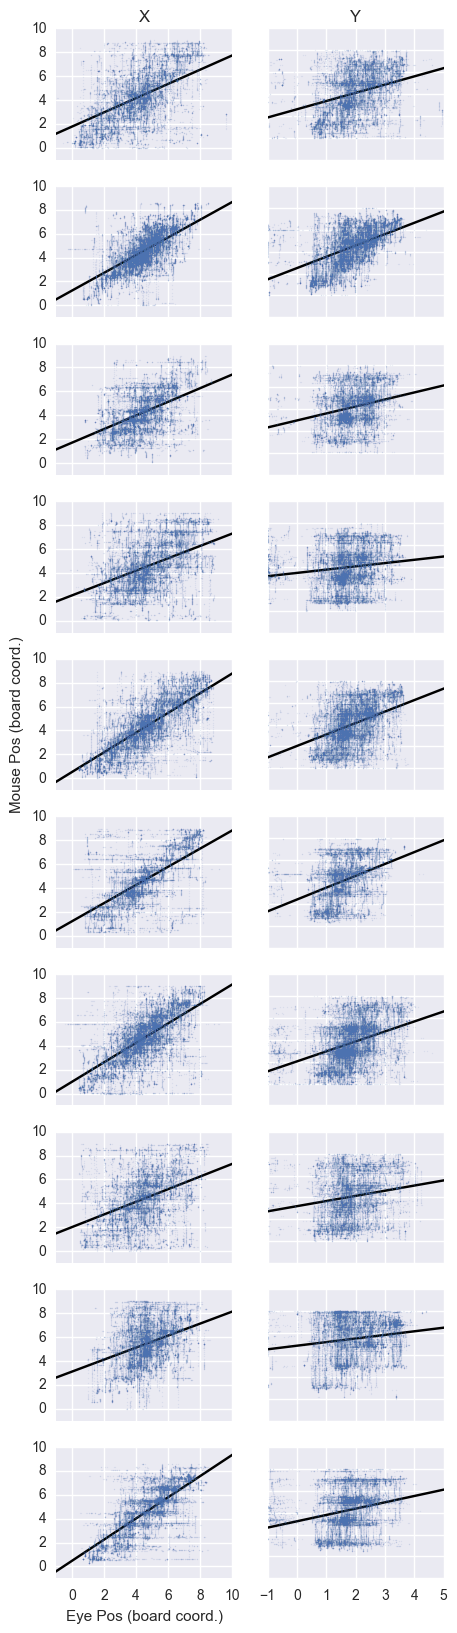

In [133]:
fig, axes = plt.subplots(len(e_list), 2, figsize=(5, 20))
for i in range(len(e_list)):
    for j, c in enumerate(['x', 'y']):
        tt = t[i].loc[pd.notnull(t[i]['eye'+c])&pd.notnull(t[i]['mou'+c])&(t[i]['task']=='playing')]
        lr = stats.linregress(tt['eye'+c], tt['mou'+c])
        print(str(i), c, lr.rvalue, lr.pvalue)
        axes[i, j].plot([-2, 11], [-2*lr.slope+lr.intercept, 11*lr.slope+lr.intercept], color='black')
        axes[i, j].plot(tt['eye'+c], tt['mou'+c], linestyle='none', marker='o', alpha=.1, markersize=1)

        
plt.setp(axes[:, 0], xlim=[-1, 10], ylim=[-1, 10])
plt.setp(axes[:, 1], xlim=[-1, 5], ylim=[-1, 5], yticklabels=[])
plt.setp(axes[:-1, :], xticklabels=[])
plt.setp(axes[-1, 0], xlabel='Eye Pos (board coord.)')
plt.setp(axes[4, 0], ylabel='Mouse Pos (board coord.)')
plt.setp(axes[0, 0], title='X')
plt.setp(axes[0, 1], title='Y')

sns.despine()

# Histograms

In [13]:
ext = t[0]
ext.loc[(ext['task']=='playing')&(ext['mouflag']==1)&(ext['turn']==2), :]

,eyex,eyey,eyeflag,moux,mouy,mouflag,turn,task,ts,eyedur,moudur,eyetile,moutile
1429294332363,1.203088,1.676112,NaN,4.967697,3.834395,1.0,2.0,playing,1429294332363,NaN,-8.0,16.288097,39.0
1429294332371,1.203088,1.676112,NaN,5.068820,3.605096,1.0,2.0,playing,1429294332371,NaN,-6.0,16.288097,37.0
1429294332377,1.203088,1.676112,NaN,5.207865,3.388535,1.0,2.0,playing,1429294332377,NaN,-8.0,16.288097,35.0
1429294332385,1.203088,1.676112,NaN,5.372191,3.197452,1.0,2.0,playing,1429294332385,NaN,-9.0,16.288097,34.0
1429294332394,1.203088,1.676112,NaN,5.511236,2.968153,1.0,2.0,playing,1429294332394,NaN,-7.0,16.288097,32.0
1429294332401,1.203088,1.676112,NaN,5.713483,2.777070,1.0,2.0,playing,1429294332401,NaN,-9.0,16.288097,30.0
1429294332410,1.203088,1.676112,NaN,5.877809,2.573248,1.0,2.0,playing,1429294332410,NaN,-9.0,16.288097,29.0
1429294332419,1.203088,1.676112,NaN,6.042135,2.382166,1.0,2.0,playing,1429294332419,NaN,-6.0,16.288097,27.0
1429294332425,1.203088,1.676112,NaN,6.168539,2.280255,1.0,2.0,playing,1429294332425,NaN,-8.0,16.288097,26.0
1429294332433,1.203088,1.676112,NaN,6.294944,2.178344,1.0,2.0,playing,1429294332433,NaN,-8.0,16.288097,25.0


In [14]:
hists = ext.loc[(ext['task']=='playing')&(ext['mouflag']==1)].pivot_table(index='turn', columns='moutile', values='moudur', aggfunc=np.sum)

In [15]:
hists.loc[1, :].sum()

-11127.0

In [40]:
g = g_list[0]
g = g.loc[g['status']=='playing']
m = m_list[0]
probe = g.loc[(g['gi']==0)&(g['mi']==5), :]
endtime = probe.index.values[0]
starttime = endtime - probe['rt'].values[0]
print(endtime, starttime)
mp = m.loc[(m.index>=starttime)&(m.index<=endtime), ['x', 'y']].astype(float)
mp['tstemp'] = mp.index
mp['dur'] = -mp['tstemp'].diff(periods=-1)
mp['dur'].sum()

1.42929434615e+12 1.42929434178e+12


3142.0

In [41]:
mt = np.array([str(starttime)] + probe['mt'].values[0].split(',') + [str(endtime)]).astype(float)
mt = mt[mt >= starttime]
(mt[1:] - mt[:-1]).sum()

4370.0

In [42]:
probe['rt']

ts
1.429294e+12    4372
Name: rt, dtype: int64

In [26]:
[0] + [1]

[0, 1]